In [27]:
import os
from fastai.vision.all import *
import pandas as pd
import torch
import torch.nn as nn

In [28]:
# Base path to the data folder
base_data_path = Path('data')

# Initialize an empty DataFrame to store all the data
combined_df = pd.DataFrame()

# List all the folders in the base directory
folders = [f for f in os.listdir(base_data_path) if os.path.isdir(base_data_path/f)]

# Loop through each folder and load CSVs and image paths
for folder in folders:
    folder_path = base_data_path/folder
    
    # Load the CSV file (assumed to be named 'controls.csv')
    csv_file = folder_path/'controls.csv'
    if csv_file.exists():
        df = pd.read_csv(csv_file)
        
        # Get all image files that exist in the folder
        image_files = {f for f in os.listdir(folder_path) if f.endswith('.jpg')}
        
        # Dynamically match each row with an actual image filename
        def get_image_filename(i):
            # Construct the expected filename
            filename = f'frame_{i}.jpg'
            # Only return the filename if it exists in the folder
            if filename in image_files:
                return folder_path/filename
            else:
                return None

        # Apply the function to create a new column with actual image paths
        df['frame'] = df.index.map(get_image_filename)
        
        # Filter out rows where no corresponding image file was found
        df = df[df['frame'].notnull()]
        
        # Combine with the main DataFrame
        combined_df = pd.concat([combined_df, df], ignore_index=True)

# If combined_df is empty, raise an error
if combined_df.empty:
    raise FileNotFoundError("No valid image files found. Please check your data folders.")

# Define a function to get the control inputs for each image (as a tensor)
def get_y(row):
    return tensor([row['steering'], row['throttle'], row['brake']])

# Define a function to get the image path for each row
def get_x(row):
    return row['frame']  # Path is already constructed in 'combined_df'

# DataBlock for regression task
dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),  # Images as input, continuous labels as output
    get_x=get_x,  # Get image path
    get_y=get_y,  # Get control inputs as a tensor
    splitter=RandomSplitter(valid_pct=0.3),  # Split train/validation
    item_tfms=Resize((94,398))
)

# Create DataLoaders
dls = dblock.dataloaders(combined_df)

In [29]:

nfeatures = 512 # resnet34 has 512 features before the head
features_out = 3 # throttle,steering,brake
body = create_body(resnet34(), pretrained=True)

head = create_head(nfeatures, features_out)

model = nn.Sequential(body,head, nn.Tanh())




Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\robve.LAPTOP-PCBR1UJF/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:07<00:00, 13.8MB/s]
c:\Users\robve.LAPTOP-PCBR1UJF\AppData\Local\Programs\Python\Python310\lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
c:\Users\robve.LAPTOP-PCBR1UJF\AppData\Local\Programs\Python\Python310\lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


c:\Users\robve.LAPTOP-PCBR1UJF\AppData\Local\Programs\Python\Python310\lib\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.lo

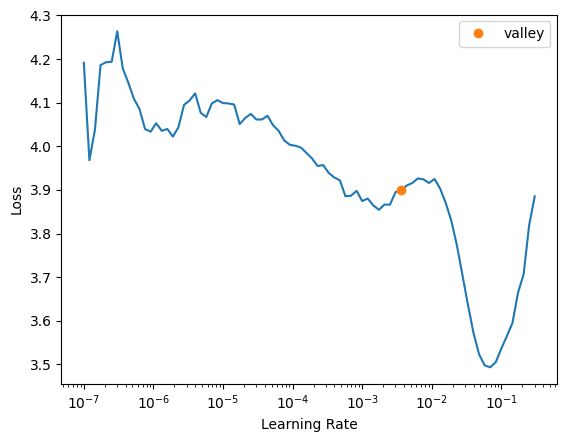

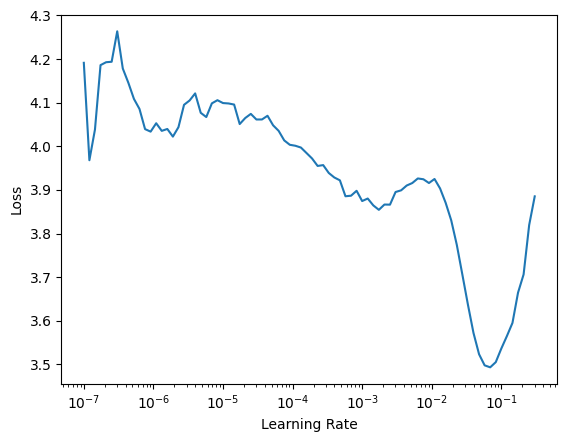

In [30]:
# Define the learner with a pretrained ResNet model
learn = vision_learner(dls, resnet50, pretrained=True, loss_func=MSELossFlat())
# learn = Learner(
#     dls, 
#     model, 
#     loss_func=MSELossFlat(),
# )

learn.freeze()

learn.to_fp16()


learn.lr_find()
learn.recorder.plot_lr_find()


Training the model


epoch,train_loss,valid_loss,time


Evaluating the model


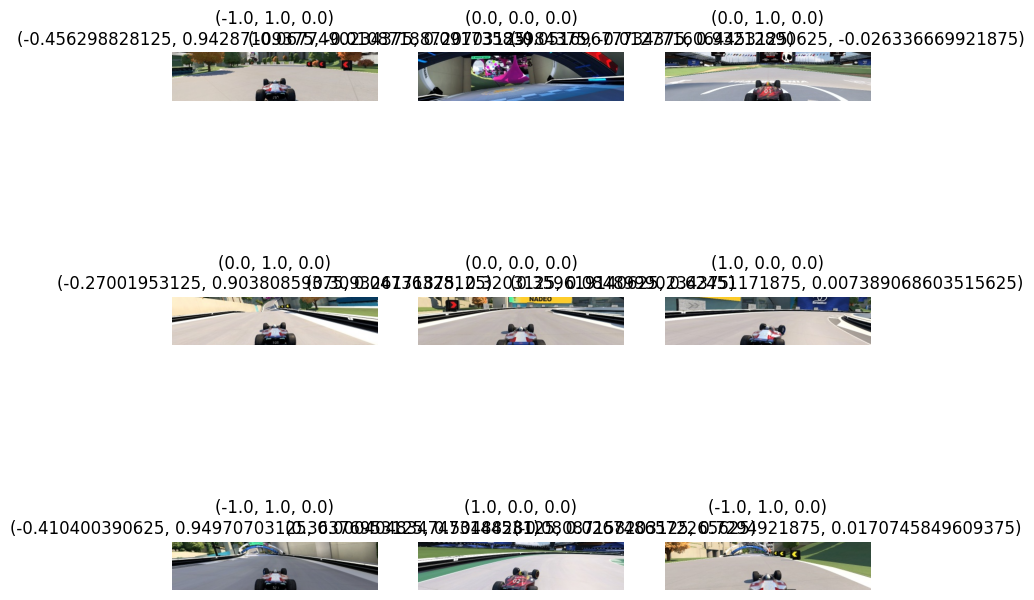

In [31]:
# Fine-tune the model
optimal_lr = 0.1
print("Training the model")
#learn.fine_tune(5)
learn.fit_one_cycle(5, lr_max=optimal_lr)



# Evaluate the model on the validation set
print("Evaluating the model")
learn.validate()
learn.show_results()

# Save the entire model for future us
learn.export('trackmania_learner_fp16_custom_head.pkl')

It sounds like your model is having trouble with predicting turns, which suggests it might not be capturing the complex features necessary for accurate steering predictions. Here are some suggestions to potentially improve your model's performance:

### 1. **Data Quality & Augmentation**
   - **Data Diversity**: Ensure you have a diverse set of driving scenarios, including different turns, lighting conditions, and any edge cases (sharp turns, U-turns, etc.). If your data isn't representative, the model won't generalize well.
   - **Data Augmentation**: Consider adding data augmentation techniques to introduce variety into your data:
     - **Brightness and Contrast** adjustments to simulate different lighting conditions.
     - **Random Crops or Jitters** to simulate slight variations in camera angles.
     - **Horizontal Flips** might be helpful if turns are symmetrical (i.e., left and right turns should have similar patterns).
   - **Frame Sequencing**: Instead of predicting control inputs from a single image, consider using a sequence of images (e.g., 3-5 frames) to provide temporal context. This way, the model gets a sense of movement direction.

### 2. **Model Improvements**
   - **Architecture**: The ResNet34 backbone may not be enough to capture the subtleties of complex turns. Consider deeper networks like ResNet50 or EfficientNet.
   - **Custom Head**: Instead of a simple fully connected head:
     - Add additional **fully connected layers** with dropout to improve learning of complex patterns.
     - Introduce **batch normalization** layers between hidden layers to stabilize training.
   - **Output Activation**: You're using `nn.Tanh()` in the output, which might limit your range. If your control inputs vary more broadly (e.g., steering can be beyond [-1,1]), consider scaling the outputs or using a different activation.

### 3. **Loss Function & Metrics**
   - **Loss Function**: While `MSELoss` works for regression, it might not be the best for nuanced steering corrections:
     - Consider using a **weighted loss** if certain actions (like turning) are more important to get right.
     - Implement **Cosine Similarity** loss or **Huber loss**, which can be less sensitive to outliers.
   - **Additional Metrics**: Monitor more than just validation loss, like **steering error**, **absolute error**, or **correlation coefficients** between predicted and true values for each control parameter. This can help diagnose if steering predictions are significantly worse than throttle.

### 4. **Training Techniques**
   - **Learning Rate Finder**: Use FastAI’s `lr_find()` to identify the best learning rate. Sometimes the default can be too aggressive or too conservative.
   - **One-Cycle Policy**: When fine-tuning, use `fit_one_cycle` instead of `fine_tune`, as it can help avoid local minima.
   - **Longer Fine-Tuning**: Increase the number of fine-tuning epochs. Training for only 5 epochs might not be enough, especially if the steering predictions aren't improving.
   - **Gradual Unfreezing**: Unfreeze the model layers gradually instead of all at once, retraining each section to stabilize learning.

### 5. **Sequence Data Input (Optional but Advanced)**
   - If your car struggles specifically with steering, your model might need temporal context (e.g., is the car approaching a turn?). Consider adding a **temporal component**:
     - Instead of single images, use a **sequence of consecutive frames** (e.g., 5 frames) as input.
     - Use architectures like **ConvLSTM** or **3D-CNNs**, which can better capture the dynamics of turns.

### 6. **Use a Segmentation Model (Optional)**
   - Consider using a segmentation model or adding segmentation information to better understand the track:
     - Pre-train a segmentation model that identifies key features (track boundaries, road edges, etc.).
     - Use this information as additional channels or features to the main model, enhancing its understanding of the environment.

### 7. **Data Normalization**
   - Double-check that your inputs (images) are normalized correctly to the range expected by the pre-trained ResNet.
   - Ensure your target outputs (`steering`, `throttle`, `brake`) are normalized to a consistent range, ideally between [-1, 1] or [0, 1].

### 8. **Regularization Techniques**
   - Introduce **dropout layers** in the custom head to mitigate overfitting.
   - Consider **weight decay** for your optimizer to penalize overly complex solutions.

### 9. **Error Analysis**
   - **Visualize Predictions**: Visualize the car's predicted controls versus ground truth for specific turns. Identify where it fails—sharp lefts? Wide right turns? Visualizations can guide you on what might be missing.
   - **Overfitting**: Check if the model is overfitting by monitoring training and validation losses. If the gap is large, you might need more data or stronger regularization.

### 10. **Advanced Optimization**
   - Experiment with **AdamW optimizer** instead of SGD or Adam.
   - Tune the **learning rate schedule** to better adapt the learning process.

By incorporating these strategies, your model might become better at recognizing complex driving scenarios and improve its turning behavior. The key is understanding where it's struggling (e.g., specific turn types) and iteratively refining the data, architecture, and training strategies accordingly.